## Using UMAP on the DEPI data

The DEPI project is aiming to use probabilistic unsupervised learning methods like Adversarial Auto-Encoders to try to understand the latent manifold structure of neural imaging data.

An alternative dimensionality reduction technique is manifold learning, and a new method for this is "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction" by Leland McInnes and John Healy: https://arxiv.org/abs/1802.03426v1

The authors provide practical efficient code for their method https://github.com/lmcinnes/umap so let's try it on the DEPI dataset.

First install UMAP.  I did so using a Python3 Conda environment (previously installed with `miniconda` into `$HOME/miniconda3`) like this:

```
git clone https://github.com/lmcinnes/umap
cd umap
. ~/miniconda3/bin/activate
conda install seaborn # just needed for UMAP example notebook
pip install -v .
```

In [2]:
import sys
import numpy as np

import nibabel

# Assuming we have already installed UMAP as above
import umap





In [3]:
import matplotlib.pyplot as plt


In [6]:

sys.path.append("../pytorch")
import depiloader


Load the data.


We have 2226 scans, each of size 45 x 54 x 45 in the 4mm resolution. The whole lot is about 1gb of memory so we can load it directly.

We'll also normalize so all images have max 1.0.

In [10]:

data = np.stack(nibabel.load(fn).get_data() for fn in depiloader.DepiDataset.find_files("/home/ben/sync/code/AION/depi", "4mm"))
data = data.reshape(data.shape[0],-1)
normdata =  data / data.max(axis=1)[:,np.newaxis]

labels = np.array([1 if '_ASD_' in fn else 0 
                   for fn in depiloader.DepiDataset.find_files("/home/ben/sync/code/AION/depi", "4mm")])


UMAP is very fast and fits in around 20s on my laptop without GPU:

In [36]:
# Specify UMAP parameters
# n_components is the latent dimension
# n_neighbours is the number of 
#     nearest-neighbour data points to use to build
#     the embedding graph.
um = umap.UMAP(n_components=3,
               n_neighbors=15,
               min_dist=0.2,
              )

%time u = um.fit_transform(normdata)


CPU times: user 24.6 s, sys: 1.7 s, total: 26.3 s
Wall time: 17.5 s


/home/ben/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


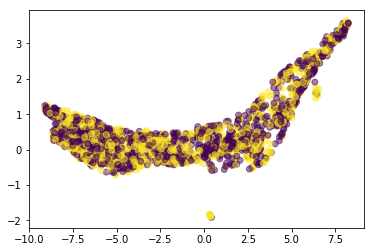

In [37]:
# Plot the first two components coloured by ASD/CON label
fig = plt.figure()
plt.scatter(u[:,0],u[:,1], c=labels,alpha=0.5)
fig.show()


We see by the fact the the labels are fairly homogenously mixed together that the default settings, and Euclidean distance, don't seem to be a doing a good job of separating the diagnostic categories.

There are a few isolated points, it would be interesting to understand how those differ.





In [42]:

um = umap.UMAP(n_components=2,
               n_neighbors=15,
              )

%time u = um.fit_transform(data)

CPU times: user 24 s, sys: 1.32 s, total: 25.3 s
Wall time: 16.8 s


## Skipping the normalization

/home/ben/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


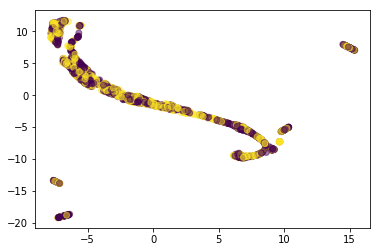

In [43]:
# Plot the first two components coloured by ASD/CON label
fig = plt.figure()
plt.scatter(u[:,0],u[:,1], c=labels,alpha=0.5)
fig.show()


If we don't normalize first, I see embeddings which are stretched out - I think UMAP with Euclidean distance sees the scaling as the most important parameter on an effectively 1d manifold.

## IPywidgets 
By using the `ipywidgets` package you can get interactive 3d displays useful both for the latent point cloud, and for volumetric displays of the neural imaging data.
But they don't render and save well, they can only be used interactively.

It would be interesting to be able to link a volume rendering of an individual patient to a point in the point cloud, to compare what changes when moving through the manifold.

In [33]:
import ipyvolume

In [35]:
ipyvolume.quickscatter(*u.T)

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scatters=[Scatter(color_selected=array('white',
      dtype='<U5'), size=array(2), size_selected=array(2.6), x=array([ 2.93230845,  3.57218207, -1.91658833, ...,  6.44693462,
       -6.63342851, -4.29293647]), y=array([-0.19738499, -0.12331483,  1.10634485, ..., -0.27860805,
        1.78978191,  1.49955604]), z=array([-3.387812  , -3.29309054, -3.88254565, ..., -3.40506031,
       -2.80296446, -3.28596314]))], style={'axes': {'visible': True, 'label': {'color': 'black'}, 'ticklabel': {'color': 'black'}, 'color': 'black'}, 'box': {'visible': True}, 'background-color': 'white'}, tf=None, width=400, xlim=[-6.988427675219431, 9.436632593604418], ylim=[-0.6074750505056188, 2.0942325890870097], zlim=[-5.973151482779177, 1.0]),))